## 전처리

In [52]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dbfread import DBF
from haversine import haversine
from tqdm.notebook import tqdm
%matplotlib inline
import platform
import pickle
import re
platform.system()
if platform.system() == 'Darwin': # Mac 환경 폰트 설정
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': # Windows 환경 폰트 설정
    plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정
%config InlineBackend.figure_format = 'retina'
!pip install dbfread
!pip install haversine

## SKT API 서울시 구별 성별 연령별 일자별 시간별 유동인구

In [131]:
time01 = pd.read_csv('./Floating_Population_2001.csv')
time01

,일자,시간(1시간단위),연령대(10세단위),성별,시,군구,유동인구수
0,20200101,0,70,여성,서울,중구,7910
1,20200101,1,20,여성,서울,중구,12330
2,20200101,1,40,여성,서울,구로구,34400
3,20200101,1,40,여성,서울,서대문구,24400
4,20200101,1,50,여성,서울,구로구,36590
...,...,...,...,...,...,...,...
223195,20200131,23,30,남성,서울,동대문구,27600
223196,20200131,23,50,여성,서울,양천구,38680
223197,20200131,23,70,남성,서울,영등포구,14790
223198,20200131,23,70,여성,서울,서초구,16990


In [132]:
time01 = pd.read_csv('./Floating_Population_2001.csv')
time02 = pd.read_csv('./Floating_Population_2002.csv')
time03 = pd.read_csv('./Floating_Population_2003.csv')
time04 = pd.read_csv('./Floating_Population_2004.csv')
time05 = pd.read_csv('./Floating_Population_2005.csv')
time06 = pd.read_csv('./Floating_Population_2006.csv')
time07 = pd.read_csv('./Floating_Population_2007.csv')

In [133]:
time = pd.concat([time01, time02, time03, time04, time05, time06, time07])
time

,일자,시간(1시간단위),연령대(10세단위),성별,시,군구,유동인구수
0,20200101,0,70,여성,서울,중구,7910
1,20200101,1,20,여성,서울,중구,12330
2,20200101,1,40,여성,서울,구로구,34400
3,20200101,1,40,여성,서울,서대문구,24400
4,20200101,1,50,여성,서울,구로구,36590
...,...,...,...,...,...,...,...
223195,20200731,22,20,여성,서울,구로구,29360
223196,20200731,22,20,여성,서울,성북구,32900
223197,20200731,22,30,남성,서울,강동구,34010
223198,20200731,23,30,여성,서울,서대문구,21960


In [134]:
#시는 다 서울이라 필요없다.
del time['시']

In [135]:
time.columns = ['date', 'time', 'age', 'sex', 'gu' , 'ppl']

In [136]:
time

,date,time,age,sex,gu,ppl
0,20200101,0,70,여성,중구,7910
1,20200101,1,20,여성,중구,12330
2,20200101,1,40,여성,구로구,34400
3,20200101,1,40,여성,서대문구,24400
4,20200101,1,50,여성,구로구,36590
...,...,...,...,...,...,...
223195,20200731,22,20,여성,구로구,29360
223196,20200731,22,20,여성,성북구,32900
223197,20200731,22,30,남성,강동구,34010
223198,20200731,23,30,여성,서대문구,21960


In [137]:
time['datetime'] = time['date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
time
                                                           

,date,time,age,sex,gu,ppl,datetime
0,20200101,0,70,여성,중구,7910,2020-01-01
1,20200101,1,20,여성,중구,12330,2020-01-01
2,20200101,1,40,여성,구로구,34400,2020-01-01
3,20200101,1,40,여성,서대문구,24400,2020-01-01
4,20200101,1,50,여성,구로구,36590,2020-01-01
...,...,...,...,...,...,...,...
223195,20200731,22,20,여성,구로구,29360,2020-07-31
223196,20200731,22,20,여성,성북구,32900,2020-07-31
223197,20200731,22,30,남성,강동구,34010,2020-07-31
223198,20200731,23,30,여성,서대문구,21960,2020-07-31


In [138]:
time = time[['datetime', 'date', 'time', 'gu', 'age', 'ppl', 'sex']]
time

,datetime,date,time,gu,age,ppl,sex
0,2020-01-01,20200101,0,중구,70,7910,여성
1,2020-01-01,20200101,1,중구,20,12330,여성
2,2020-01-01,20200101,1,구로구,40,34400,여성
3,2020-01-01,20200101,1,서대문구,40,24400,여성
4,2020-01-01,20200101,1,구로구,50,36590,여성
...,...,...,...,...,...,...,...
223195,2020-07-31,20200731,22,구로구,20,29360,여성
223196,2020-07-31,20200731,22,성북구,20,32900,여성
223197,2020-07-31,20200731,22,강동구,30,34010,남성
223198,2020-07-31,20200731,23,서대문구,30,21960,여성


In [143]:
#저장
with open('time.pkl', 'wb') as f:
    pickle.dump(time, f)

In [ ]:
def pklopen(route):
    with open('{}'.format(route), 'rb') as f:
        df = pickle.load(f)
    return df
time = pklopen('./time.pkl')

In [139]:
#구의 종류
time['gu'].unique()

array(['중구', '구로구', '서대문구', '성동구', '송파구', '용산구', '성북구', '영등포구', '동작구',
       '중랑구', '노원구', '양천구', '강남구', '강서구', '관악구', '강동구', '은평구', '마포구',
       '도봉구', '종로구', '서초구', '동대문구', '강북구', '광진구', '금천구'], dtype=object)

In [140]:
#나이 종류
time['age'].unique()

array([70, 20, 40, 50, 30, 60], dtype=int64)

In [141]:
time_sorted = time.sort_values(by=['age', 'datetime', 'time'], axis=0)
time_sorted

,datetime,date,time,gu,age,ppl,sex
4109,2020-01-01,20200101,0,금천구,20,14220,여성
6151,2020-01-01,20200101,0,중랑구,20,25030,남성
10330,2020-01-01,20200101,0,강남구,20,43680,남성
24665,2020-01-01,20200101,0,도봉구,20,19950,남성
30655,2020-01-01,20200101,0,양천구,20,29620,남성
...,...,...,...,...,...,...,...
195866,2020-07-31,20200731,23,성동구,70,13530,여성
199770,2020-07-31,20200731,23,금천구,70,10740,여성
221273,2020-07-31,20200731,23,노원구,70,16500,남성
221274,2020-07-31,20200731,23,중랑구,70,13350,남성


In [142]:
time_sorted.set_index(['datetime', 'time'])

date   gu  age    ppl sex
datetime   time                               
2020-01-01 0     20200101  금천구   20  14220  여성
           0     20200101  중랑구   20  25030  남성
           0     20200101  강남구   20  43680  남성
           0     20200101  도봉구   20  19950  남성
           0     20200101  양천구   20  29620  남성
...                   ...  ...  ...    ...  ..
2020-07-31 23    20200731  성동구   70  13530  여성
           23    20200731  금천구   70  10740  여성
           23    20200731  노원구   70  16500  남성
           23    20200731  중랑구   70  13350  남성
           23    20200731  마포구   70  17770  여성

[1524000 rows x 5 columns]

## 구별, 일별, 시간별 같은 연령끼리 유동인구

In [146]:
timeday = time_sorted.groupby(['datetime', 'date', 'gu', 'age', 'time']).sum()
timeday = timeday.reset_index()
#2월 1일 기준 20대 한번 보자(1월은 명절)
k = timeday[timeday['datetime']=='2020-02-01'].head(24)
k

,datetime,date,gu,age,time,ppl
111600,2020-02-01,20200201,강남구,20,0,85360
111601,2020-02-01,20200201,강남구,20,1,83380
111602,2020-02-01,20200201,강남구,20,2,81670
111603,2020-02-01,20200201,강남구,20,3,80830
111604,2020-02-01,20200201,강남구,20,4,80150
111605,2020-02-01,20200201,강남구,20,5,79960
111606,2020-02-01,20200201,강남구,20,6,80830
111607,2020-02-01,20200201,강남구,20,7,83890
111608,2020-02-01,20200201,강남구,20,8,92110
111609,2020-02-01,20200201,강남구,20,9,104370


Text(0.5, 1.0, '2월1일 강남구 20대의 시간별 유동인구')

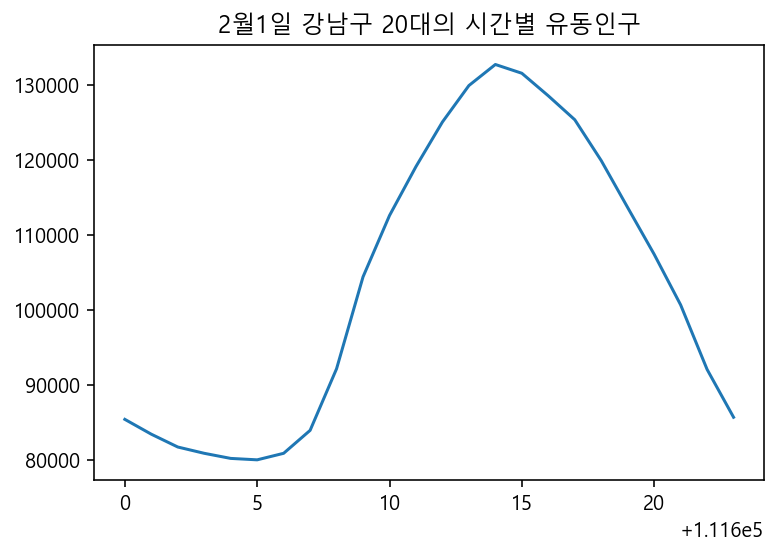

In [147]:
plt.plot(k['ppl'])
plt.title('2월1일 강남구 20대의 시간별 유동인구')

## 이제 구별 일별 민감도(연령별은 나중에 추가하기)

In [174]:
timegu = time_sorted.groupby(['datetime', 'date','gu']).sum()
timegu = timegu.reset_index()
del timegu['age']
del timegu['time']
timegu.set_index(['datetime'], inplace=True)
timegu

,date,gu,ppl
datetime,,,
2020-01-01,20200101,강남구,11001340
2020-01-01,20200101,강동구,8296230
2020-01-01,20200101,강북구,6160610
2020-01-01,20200101,강서구,10998410
2020-01-01,20200101,관악구,10003990
...,...,...,...
2020-07-31,20200731,용산구,5271470
2020-07-31,20200731,은평구,7699220
2020-07-31,20200731,종로구,5752320


In [156]:
weekly_timegu = timegu.resample('W-Sun').sum()

In [157]:
weekly_timegu

,date,ppl
datetime,,
2020-01-05,2525012875,991816400
2020-01-12,3535019075,1412750590
2020-01-19,3535020300,1408781130
2020-01-26,3535021525,1323341710
2020-02-02,3535026200,1381499610
2020-02-09,3535036050,1387818200
2020-02-16,3535037275,1385614380
2020-02-23,3535038500,1561186800
2020-03-01,3535041500,1375153010


## resample의 how가 없어졌네;

In [158]:
timegu

,date,gu,ppl
datetime,,,
2020-01-01,20200101,강남구,11001340
2020-01-01,20200101,강동구,8296230
2020-01-01,20200101,강북구,6160610
2020-01-01,20200101,강서구,10998410
2020-01-01,20200101,관악구,10003990
...,...,...,...
2020-07-31,20200731,용산구,5271470
2020-07-31,20200731,은평구,7699220
2020-07-31,20200731,종로구,5752320


In [175]:
timegu.groupby(pd.Grouper(freq='W')).sum()

,date,ppl
datetime,,
2020-01-05,2525012875,991816400
2020-01-12,3535019075,1412750590
2020-01-19,3535020300,1408781130
2020-01-26,3535021525,1323341710
2020-02-02,3535026200,1381499610
2020-02-09,3535036050,1387818200
2020-02-16,3535037275,1385614380
2020-02-23,3535038500,1561186800
2020-03-01,3535041500,1375153010
